## **Uczenie maszynowe** - laboratorium 2: Klasyfikacja algorytmem k-najbliższych sąsiadów (k-nn)
**Stefan Borek**

In [2]:
import sklearn
from sklearn.datasets import load_wine, load_iris
import numpy
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.datasets import load_iris
import pandas as pd
import plotly.express as px

### **Wino🍷**

In [3]:
from ucimlrepo import fetch_ucirepo 

wine = fetch_ucirepo(id=109) 
  
df_wine = wine.data.features.copy()
df_wine['class'] = wine.data.targets.values
df_wine.head()

,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [4]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_wine["Alcohol"], y=df_wine["Color_intensity"],
                         mode='markers',
                         name='RI vs Na',
                         marker=dict(color=df_wine['class'], colorscale='Rainbow', showscale=False)))  # showscale to show the color scale

fig.update_xaxes(title_text="Alcohol (%)")
fig.update_yaxes(title_text="Color intensity")

fig.update_layout(height=600, width=800, title_text="Wine Dataset🍷: Feature Comparisons")

fig.show()

### **Kwiaty**💐

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [6]:
species_encode = {spec: i for i, spec in enumerate(df_iris["species"].values.unique())}
species_decode = {i: spec for i, spec in enumerate(df_iris["species"].values.unique())}
species_encode, species_decode

({'setosa': 0, 'versicolor': 1, 'virginica': 2},
 {0: 'setosa', 1: 'versicolor', 2: 'virginica'})

### **kodowanie kolumny kategorycznej**

In [7]:
df_iris["y"] = df_iris["species"].apply(lambda x: species_encode.get(x, -1))
df_iris["y"].values.unique()

[0, 1, 2]
Categories (3, int64): [0, 1, 2]

In [8]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_iris["petal length (cm)"], y=df_iris["petal width (cm)"],
                         mode='markers',
                         name='petal length (cm) vs petal width (cm)',
                         marker=dict(color=df_iris["y"], colorscale='rainbow', showscale=False)))

fig.update_xaxes(title_text="petal length (cm)")
fig.update_yaxes(title_text="petal width (cm)")
fig.update_layout(height=600, width=800, title_text="Iris Dataset🌹: Feature Comparisons")

fig.show()

### **Glass**🥂

In [9]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
glass_identification = fetch_ucirepo(id=42) 
df_glass = glass_identification.data.features.copy()
df_glass['class'] = glass_identification.data.targets.values
df_glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [10]:
df_glass.columns

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'class'], dtype='object')

In [11]:
fig = go.Figure()

# Add scatter plot for RI vs Na colored by glass class
fig.add_trace(go.Scatter(x=df_glass["RI"], y=df_glass["Al"],
                         mode='markers',
                         name='RI vs Na',
                         marker=dict(color=df_glass['class'], colorscale='magma', showscale=False)))  # showscale to show the color scale

# Update x and y axes labels
fig.update_xaxes(title_text="Refractive Index (RI)")
fig.update_yaxes(title_text="Aluminium (Al)")

# Update layout
fig.update_layout(height=600, width=800, title_text="Glass Dataset: RI vs Na")

fig.show()

### **baseline**: k-nn
**iris🌹**

In [52]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedKFold

X_cols = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

In [96]:
X_iris, y_iris = df_iris[X_cols].values, df_iris["y"].values

In [80]:
def create_folds(X, y, k: int):
    """ Create cross validation folds
    Arguments:
        X (Iterable): inputs
        y (Iterable): targets
        k (int): number of folds
    
    Returns:
        list: list of folds
    """
    fold_sizes = len(X) // k
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return [indices[i * fold_sizes:(i + 1) * fold_sizes] for i in range(k)]


def cross_validate(model, X, y, k, conf_matrix: bool):
    folds = create_folds(X, y, k)
    y_true_all = []
    y_pred_all = []
    scores = []

    for fold in range(k):
        test_indices = folds[fold]
        train_indices = np.hstack([inds for i, inds in enumerate(folds) if i != fold])
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        skaler = Normalizer().fit(X_train)
        X_train_norm = skaler.transform(X_train)
        X_test_norm = skaler.transform(X_test)

        model.fit(X_train_norm, y_train)
        y_pred = model.predict(X_test_norm)

        scores.append(f1_score(y_test, y_pred, average="macro"))
        if conf_matrix:
            y_true_all.extend(y_test)
            y_pred_all.extend(y_pred)

    return scores, confusion_matrix(y_true_all, y_pred_all)

In [97]:
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
scores, conf_matrix = cross_validate(knn, X_iris, y_iris, k=5, conf_matrix=True)
print(f"Base KNN classifier mean F1 score over % fold Cross Validation: {np.mean(scores):.3f}")

Base KNN classifier mean F1 score over % fold Cross Validation: 0.946


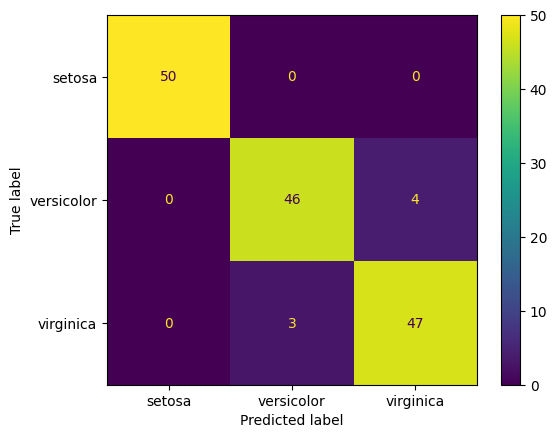

In [98]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=df_iris["species"].unique())
disp.plot()

In [127]:
from IPython.display import display, Markdown

def get_classification_results(model: object, X: np.array, y: np.array, k_folds: int):
    scores, _ = cross_validate(model, X, y, k=k_folds, conf_matrix=False)
    
    return np.mean(scores)

def plot_k_fold_scores(data, columns: list, title: str, xlabel: str, ylabel: str, color: list=None):
    df = pd.DataFrame(list(data.items()), columns=columns)
    display(Markdown(df.to_markdown()))
    color = df[xlabel] if not color else color
    plt.figure(figsize=(12, 4))
    sns.barplot(data=df, x=columns[0], y=columns[1], palette='viridis', hue=color)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(rotation=70)
    plt.ylim(0.5, 1)
    plt.show()

|    | model               |   f1-score |
|---:|:--------------------|-----------:|
|  0 | base_knn_2_fold_cv  |      0.951 |
|  1 | base_knn_5_fold_cv  |      0.969 |
|  2 | base_knn_10_fold_cv |      0.964 |

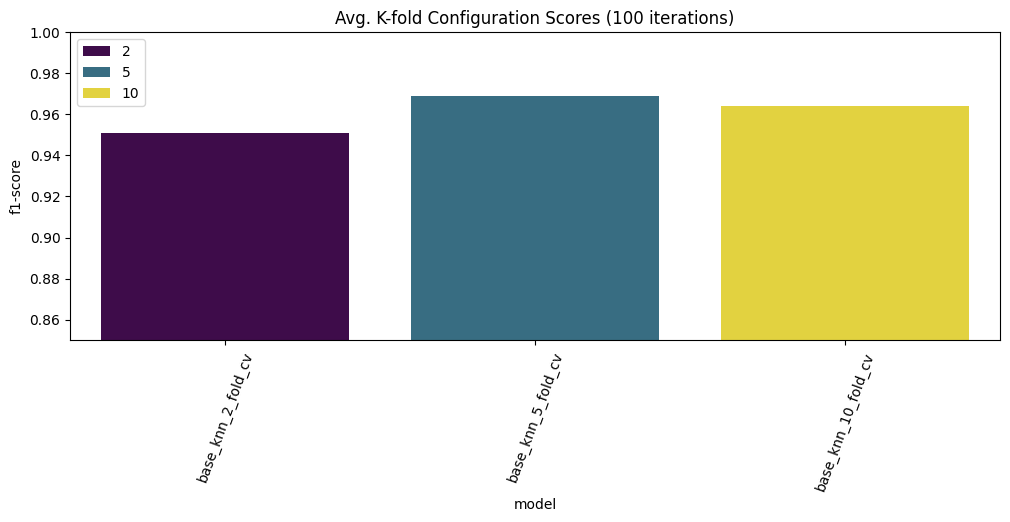

In [100]:
def kfolds_experiment(X_dataset, y_dataset):
    results = {}
    color = []
    n_samples = 100
    for i in [2, 5, 10]:
        f1 = 0
        for j in range(n_samples):
            model = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
            cv_results = get_classification_results(model, X_dataset, y_dataset, k_folds=i)
            f1 += np.average(cv_results)
        color.append(i)
        model_name = f"base_knn_{i}_fold_cv"
        results[model_name] = {}
        results[model_name] = np.round(f1 / n_samples, 3)


    plot_k_fold_scores(results, columns=["model", "f1-score"],
                    title=f"Avg. K-fold Configuration Scores ({100} iterations)",
                    xlabel="model",
                    ylabel="f1-score",
                    color=color)
    
kfolds_experiment(X_iris, y_iris)

|    |   k-neighbours |   f1-score |
|---:|---------------:|-----------:|
|  0 |              1 |      0.959 |
|  1 |              2 |      0.951 |
|  2 |              3 |      0.972 |
|  3 |              4 |      0.969 |
|  4 |              5 |      0.968 |
|  5 |              6 |      0.967 |
|  6 |              7 |      0.967 |
|  7 |              8 |      0.965 |
|  8 |              9 |      0.966 |
|  9 |             10 |      0.966 |
| 10 |             11 |      0.965 |
| 11 |             12 |      0.965 |
| 12 |             13 |      0.969 |
| 13 |             14 |      0.969 |
| 14 |             15 |      0.972 |

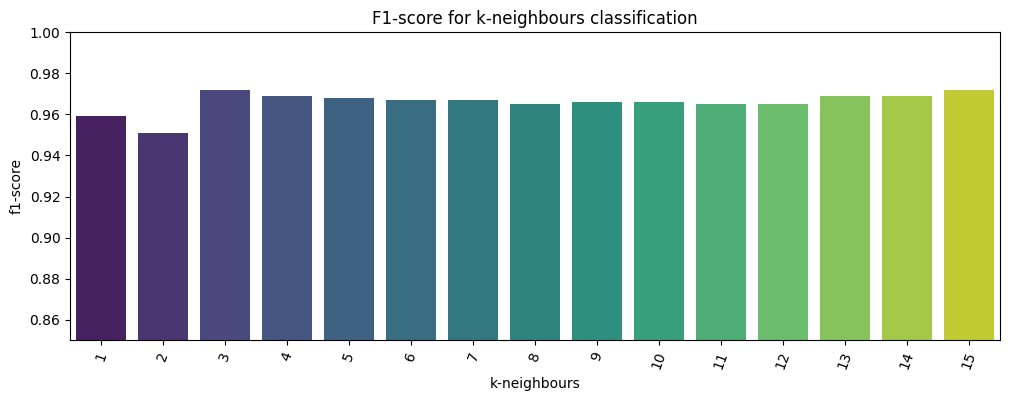

In [101]:
def kneighbours_experiment(X_dataset, y_dataset):
    results = {}
    iterations = 100
    for i in range(1, 16):
        model_name = f"{i}"
        results[model_name] = {}
        cv_results = 0
        for _ in range(100):
            model = KNeighborsClassifier(n_neighbors=i, metric="euclidean")
            cv_results += np.average(get_classification_results(model, X_dataset, y_dataset, k_folds=5))

        results[model_name] = np.round(cv_results / iterations, 3)

    plot_k_fold_scores(results,
                    columns=["k-neighbours", "f1-score"],
                    title="F1-score for k-neighbours classification",
                    xlabel="k-neighbours",
                    ylabel="f1-score"
                    )
    
kneighbours_experiment(X_iris, y_iris)

|    | k-neighbours   |   f1-score |
|---:|:---------------|-----------:|
|  0 | uniform        |      0.973 |
|  1 | distance       |      0.974 |
|  2 | inversed_sqrt  |      0.973 |

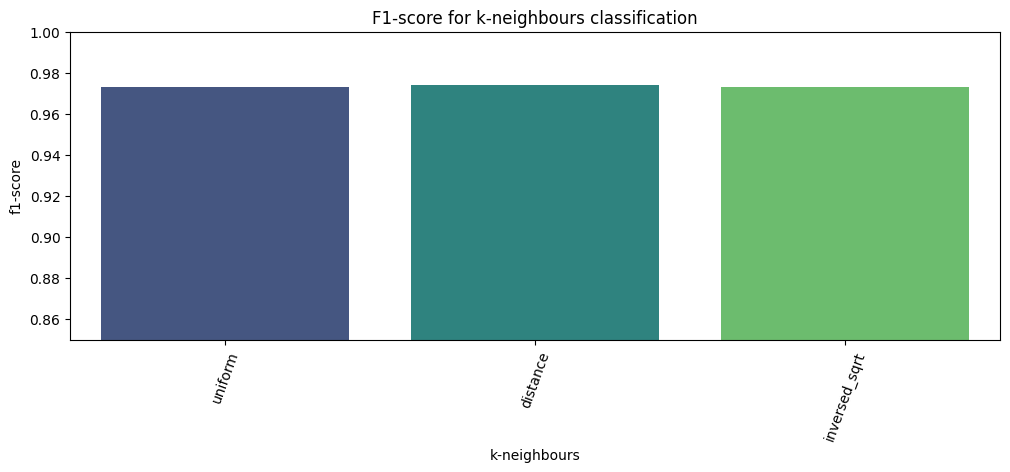

In [102]:
def inversed_sqrt(distances):
    weights = 1 / (distances + 1e-10)**2
    return weights

def voting_experiment(X_dataset, y_dataset):
    results = {}
    sample_size = 50

    for voting in ["uniform", "distance", inversed_sqrt]:
        cv_results = 0
        for _ in range(sample_size):
            model = KNeighborsClassifier(n_neighbors=i, metric="euclidean", weights=voting)
            cv_results += np.average(get_classification_results(model, X_dataset, y_dataset, k_folds=5))
        model_name = model.weights.__name__ if type(model.weights) != str else model.weights
        results[model_name] = {}
        results[model_name] = np.round(cv_results / sample_size, 3)

    plot_k_fold_scores(results,
                    columns=["k-neighbours", "f1-score"],
                    title="F1-score for k-neighbours classification",
                    xlabel="k-neighbours",
                    ylabel="f1-score"
                    )

voting_experiment(X_iris, y_iris)

|    | metric      |   f1-score |
|---:|:------------|-----------:|
|  0 | euclidean   |      0.972 |
|  1 | minkowski   |      0.973 |
|  2 | mahalanobis |      0.957 |
|  3 | cosine      |      0.971 |

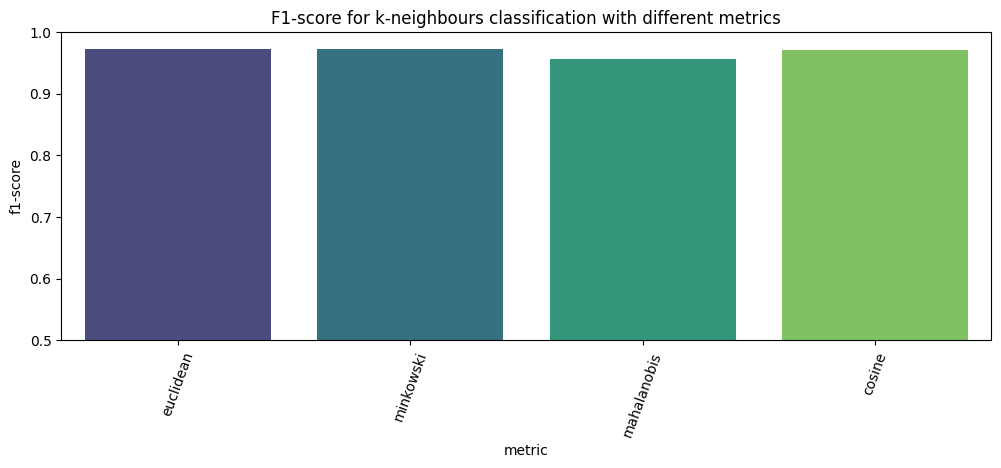

In [132]:
def metric_experiment(X_dataset, y_dataset):
    results = {}
    sample_size = 50

    models = [
        KNeighborsClassifier(n_neighbors=i, metric="euclidean"),
        KNeighborsClassifier(n_neighbors=i, metric="minkowski"),
        KNeighborsClassifier(n_neighbors=i, metric="mahalanobis", metric_params={'V': np.cov(X_dataset, rowvar=False)}),
        KNeighborsClassifier(n_neighbors=i, metric="cosine")
    ]

    for model in models:
        cv_results = 0
        for _ in range(sample_size):
            cv_results += np.average(get_classification_results(model, X_dataset, y_dataset, k_folds=5))
        model_name = model.metric
        results[model_name] = {}
        results[model_name] = np.round(cv_results / sample_size, 3)

    plot_k_fold_scores(results,
                    columns=["metric", "f1-score"],
                    title="F1-score for k-neighbours classification with different metrics",
                    xlabel="metric",
                    ylabel="f1-score"
                    )

metric_experiment(X_iris, y_iris)

## Wine🍷

In [105]:
wine_y_col = "class"
wine_X_cols = [col for col in df_wine.columns if col != wine_y_col]

X_wine, y_wine = df_wine[wine_X_cols].values, df_wine[wine_y_col].values
X_wine.shape, y_wine.shape

((178, 13), (178,))

Base KNN classifier mean F1 score over 5 fold Cross Validation: 0.783


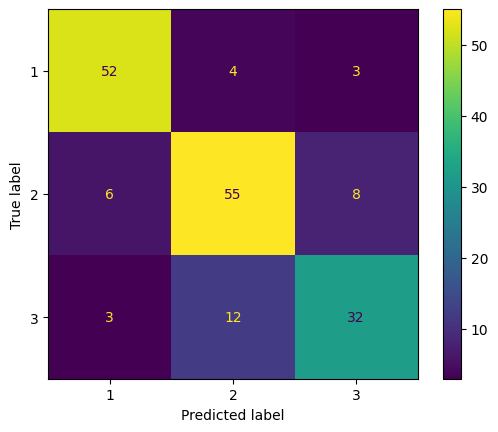

In [160]:
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
scores, conf_matrix = cross_validate(knn, X_wine, y_wine, k=5, conf_matrix=True)
print(f"Base KNN classifier mean F1 score over 5 fold Cross Validation: {np.mean(scores):.3f}")
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=df_wine[wine_y_col].unique())
disp.plot()

|    | model               |   f1-score |
|---:|:--------------------|-----------:|
|  0 | base_knn_2_fold_cv  |      0.744 |
|  1 | base_knn_5_fold_cv  |      0.795 |
|  2 | base_knn_10_fold_cv |      0.787 |

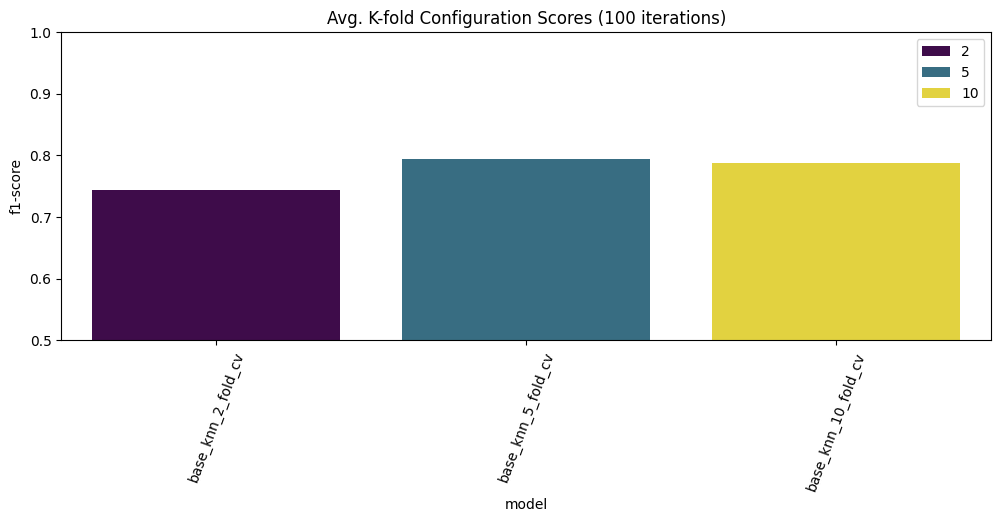

In [162]:
kfolds_experiment(X_wine, y_wine)

|    |   k-neighbours |   f1-score |
|---:|---------------:|-----------:|
|  0 |              1 |      0.825 |
|  1 |              2 |      0.755 |
|  2 |              3 |      0.788 |
|  3 |              4 |      0.789 |
|  4 |              5 |      0.794 |
|  5 |              6 |      0.791 |
|  6 |              7 |      0.79  |
|  7 |              8 |      0.792 |
|  8 |              9 |      0.783 |
|  9 |             10 |      0.782 |
| 10 |             11 |      0.769 |
| 11 |             12 |      0.763 |
| 12 |             13 |      0.759 |
| 13 |             14 |      0.744 |
| 14 |             15 |      0.751 |

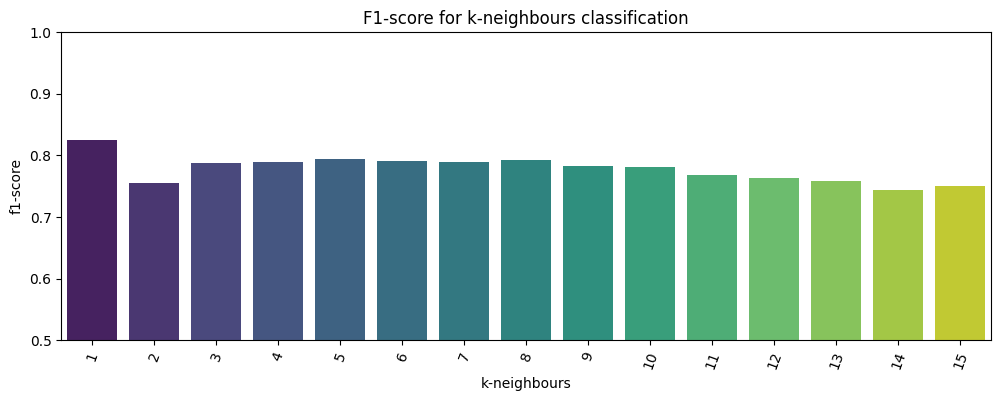

In [164]:
kneighbours_experiment(X_wine, y_wine)

|    | k-neighbours   |   f1-score |
|---:|:---------------|-----------:|
|  0 | uniform        |      0.745 |
|  1 | distance       |      0.786 |
|  2 | inversed_sqrt  |      0.807 |

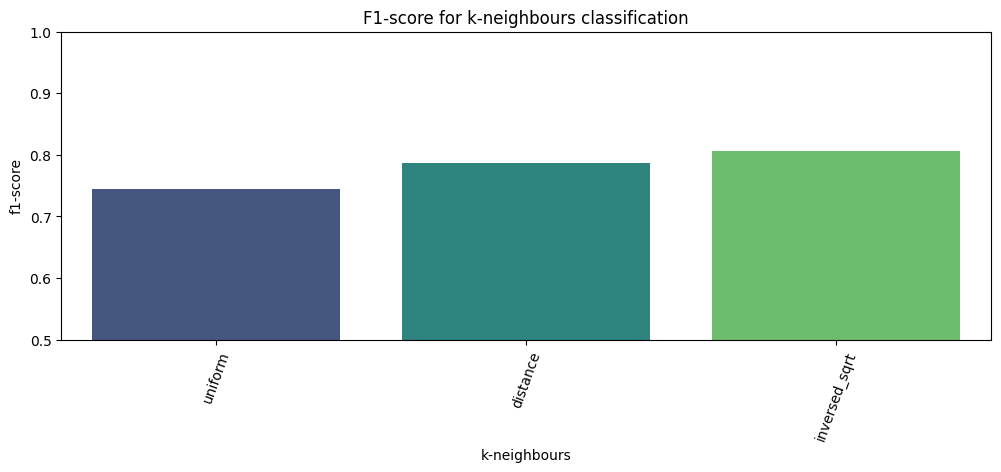

In [163]:
voting_experiment(X_wine, y_wine)

|    | metric      |   f1-score |
|---:|:------------|-----------:|
|  0 | euclidean   |      0.745 |
|  1 | minkowski   |      0.747 |
|  2 | mahalanobis |      0.775 |
|  3 | cosine      |      0.746 |

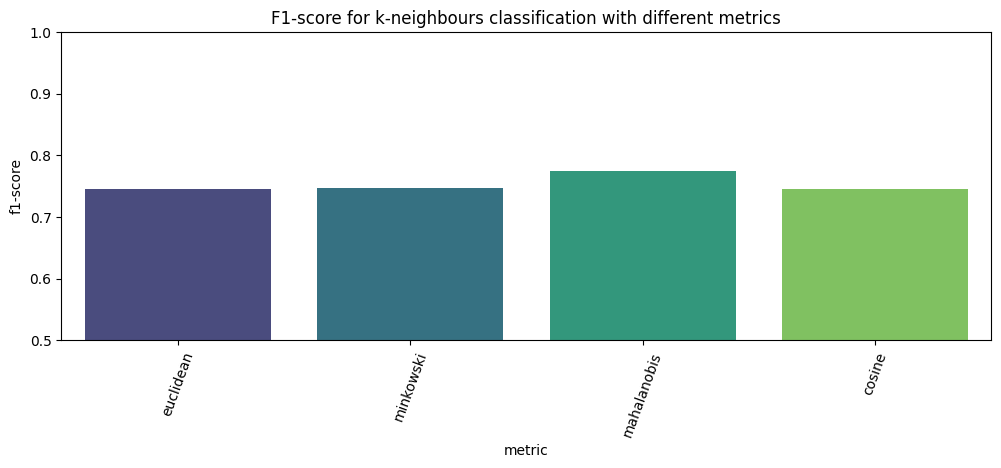

In [165]:
metric_experiment(X_wine, y_wine)

## Glass 🥂

In [124]:
glass_y_col = "class"
glass_X_cols = [col for col in df_glass.columns if col != glass_y_col]

X_glass, y_glass = df_glass[glass_X_cols].values, df_glass[glass_y_col].values
X_glass.shape, y_glass.shape

((214, 9), (214,))

Base KNN classifier mean F1 score over 5 fold Cross Validation: 0.554


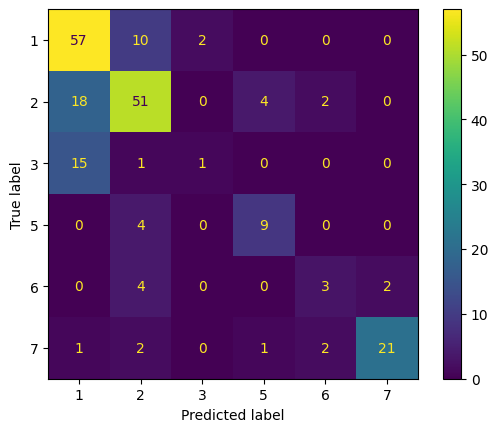

In [161]:
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
scores, conf_matrix = cross_validate(knn, X_glass, y_glass, k=5, conf_matrix=True)
print(f"Base KNN classifier mean F1 score over 5 fold Cross Validation: {np.mean(scores):.3f}")
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=df_glass[glass_y_col].unique())
disp.plot()

### Glass🥂 - porównanie ***k-fold***

|    | model               |   f1-score |
|---:|:--------------------|-----------:|
|  0 | base_knn_2_fold_cv  |      0.739 |
|  1 | base_knn_5_fold_cv  |      0.797 |
|  2 | base_knn_10_fold_cv |      0.783 |

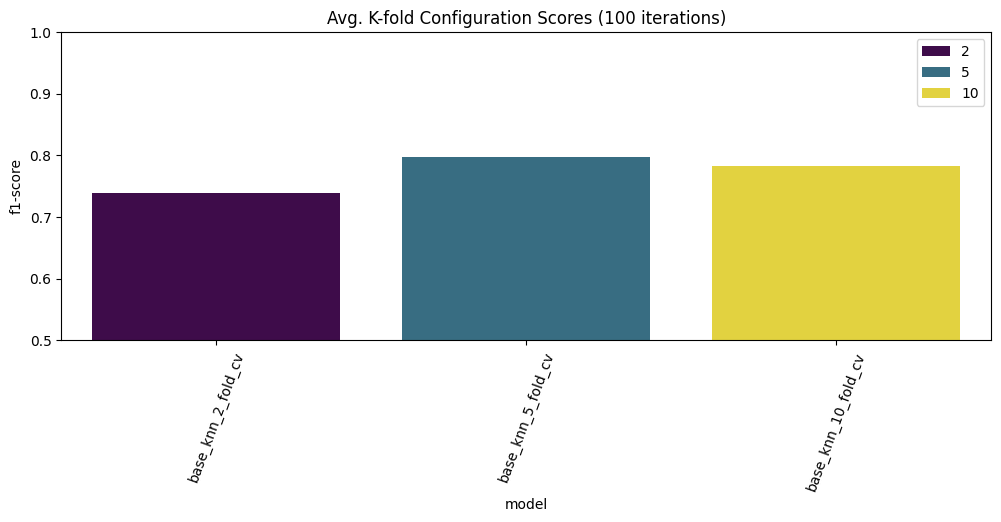

In [128]:
kfolds_experiment(X_wine, y_wine)

### Glass🥂 - porównanie ***k-neighbours***

|    |   k-neighbours |   f1-score |
|---:|---------------:|-----------:|
|  0 |              1 |      0.827 |
|  1 |              2 |      0.752 |
|  2 |              3 |      0.782 |
|  3 |              4 |      0.788 |
|  4 |              5 |      0.796 |
|  5 |              6 |      0.795 |
|  6 |              7 |      0.789 |
|  7 |              8 |      0.792 |
|  8 |              9 |      0.781 |
|  9 |             10 |      0.785 |
| 10 |             11 |      0.769 |
| 11 |             12 |      0.759 |
| 12 |             13 |      0.755 |
| 13 |             14 |      0.744 |
| 14 |             15 |      0.746 |

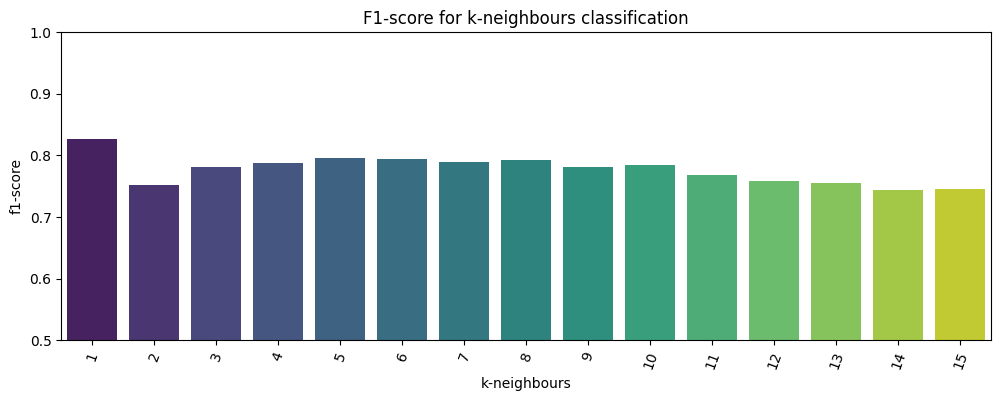

In [129]:
kneighbours_experiment(X_wine, y_wine)

### Glass🥂 - porównanie ***metody głosowania***

|    | k-neighbours   |   f1-score |
|---:|:---------------|-----------:|
|  0 | uniform        |      0.745 |
|  1 | distance       |      0.788 |
|  2 | inversed_sqrt  |      0.805 |

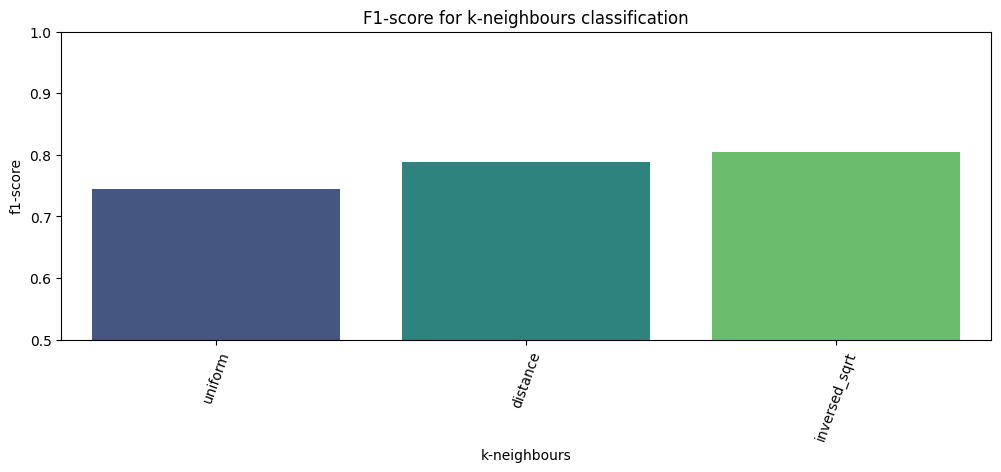

In [130]:
voting_experiment(X_wine, y_wine)

### Glass🥂 - porównanie ***metryk***

|    | metric      |   f1-score |
|---:|:------------|-----------:|
|  0 | euclidean   |      0.748 |
|  1 | minkowski   |      0.749 |
|  2 | mahalanobis |      0.774 |
|  3 | cosine      |      0.745 |

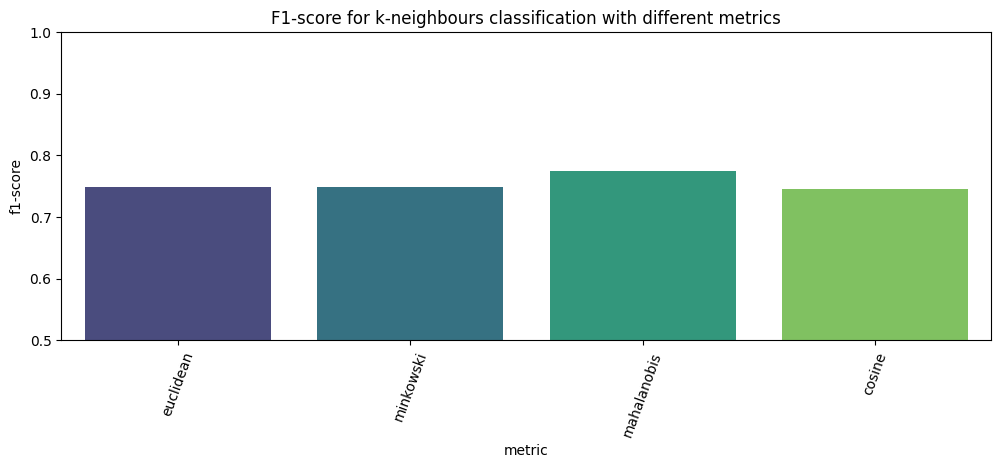

In [133]:
metric_experiment(X_wine, y_wine)

## **stratyfikacja** vs **baza**

In [156]:
from sklearn.model_selection import cross_val_score
results = {"iris":{}, "wine":{}, "glass": {}}
knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
scores_iris, _ = cross_validate(knn, X_iris, y_iris, k=5, conf_matrix=False)
scores_str_iris = cross_val_score(
    knn, X_iris, y_iris,
    cv=StratifiedKFold(n_splits=5, shuffle=True)
)

results["iris"]["base"] = np.mean(scores_iris)
results["iris"]["stratified"] = np.mean(scores_str_iris)


knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
scores_glass, _ = cross_validate(knn, X_wine, y_wine, k=5, conf_matrix=False)
scores_str_glass = cross_val_score(
    knn, X_wine, y_wine,
    cv=StratifiedKFold(n_splits=5, shuffle=True)
)
results["wine"]["base"] = np.mean(scores_glass)
results["wine"]["stratified"] = np.mean(scores_str_glass)

knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
scores_glass, _ = cross_validate(knn, X_glass, y_glass, k=5, conf_matrix=False)
scores_str_glass = cross_val_score(
    knn, X_glass, y_glass,
    cv=StratifiedKFold(n_splits=5, shuffle=True)
)

results["glass"]["base"] = np.mean(scores_glass)
results["glass"]["stratified"] = np.mean(scores_str_glass)
table_string = "| Dataset | Base | Stratified |\n"
table_string += "| ------- | ---- | ---------- |\n"
for dataset, values in results.items():
    base_score = values['base']
    stratified_score = values['stratified']
    table_string += f"| {dataset} | {base_score:.4f} | {stratified_score:.4f} |\n"

display(Markdown(table_string))

| Dataset | Base | Stratified |
| ------- | ---- | ---------- |
| iris | 0.9808 | 0.9533 |
| wine | 0.8196 | 0.6514 |
| glass | 0.5624 | 0.6542 |


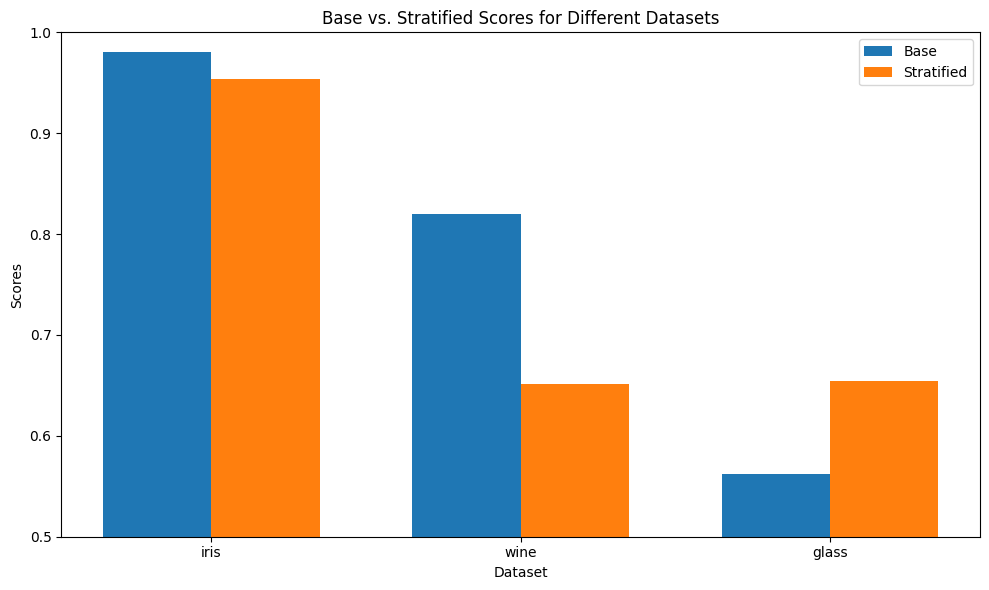

In [159]:
datasets = list(results.keys())
base_scores = [results[dataset]['base'] for dataset in datasets]
stratified_scores = [results[dataset]['stratified'] for dataset in datasets]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(datasets))

plt.bar(index, base_scores, bar_width, label='Base')
plt.bar([i + bar_width for i in index], stratified_scores, bar_width, label='Stratified')

plt.xlabel('Dataset')
plt.ylabel('Scores')
plt.title('Base vs. Stratified Scores for Different Datasets')
plt.xticks([i + bar_width/2 for i in index], datasets)
plt.ylim(0.5, 1)
plt.legend()

plt.tight_layout()
plt.show()